In [26]:
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("kubernetes_data.csv")
df.head()

,timestamp,cpu_usage,memory_usage,disk_usage,network_io,pod_status,node_status,latency_ms,error_rate,logs_anomalies,issue
0,2025-03-01 00:00:00,38.708611,39.891265,74.749873,641.763123,7,3,249.752670,2.561695,77,Pod Failure
1,2025-03-01 00:01:00,90.564288,36.632968,33.838400,464.699529,4,3,289.709806,11.712812,4,Resource Exhaustion
2,2025-03-01 00:02:00,70.879455,24.092313,45.997977,964.853540,0,1,443.822359,13.855039,86,Network Issue
3,2025-03-01 00:03:00,58.879264,58.581334,69.746048,226.788666,3,3,349.153804,16.295988,0,Pod Failure
4,2025-03-01 00:04:00,19.041678,48.129933,56.156701,591.977852,2,3,453.071377,5.988102,83,Pod Failure


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       10000 non-null  object 
 1   cpu_usage       10000 non-null  float64
 2   memory_usage    10000 non-null  float64
 3   disk_usage      10000 non-null  float64
 4   network_io      10000 non-null  float64
 5   pod_status      10000 non-null  int64  
 6   node_status     10000 non-null  int64  
 7   latency_ms      10000 non-null  float64
 8   error_rate      10000 non-null  float64
 9   logs_anomalies  10000 non-null  int64  
 10  issue           10000 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 859.5+ KB


C:\Users\Rudrresh\AppData\Local\Temp\ipykernel_15932\910495576.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["issue"], order=df["issue"].value_counts().index, palette="viridis")


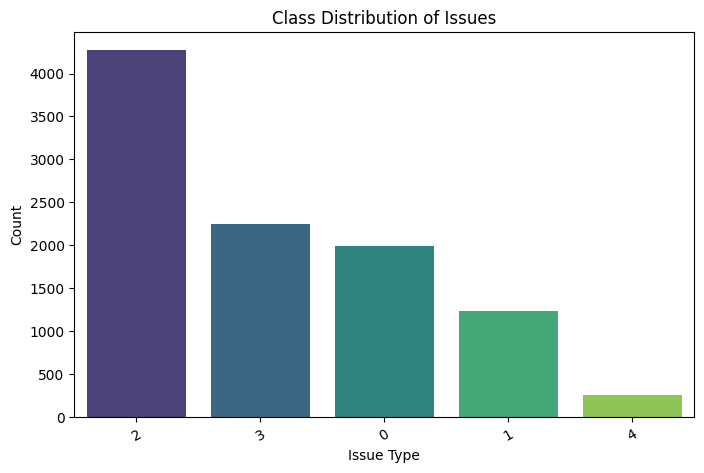

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["issue"], order=df["issue"].value_counts().index, palette="viridis")
plt.xticks(rotation=30)
plt.title("Class Distribution of Issues")
plt.xlabel("Issue Type")
plt.ylabel("Count")
plt.show()

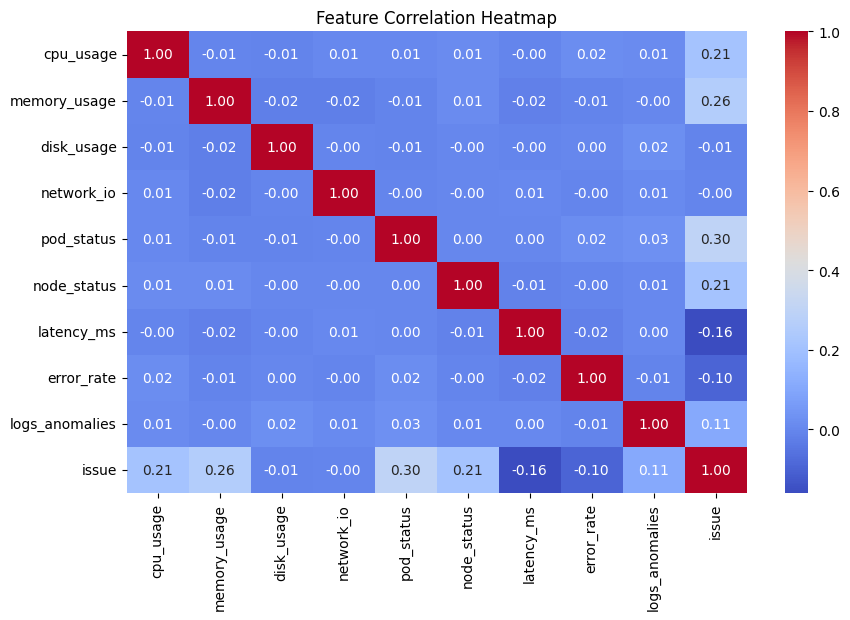

In [28]:

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

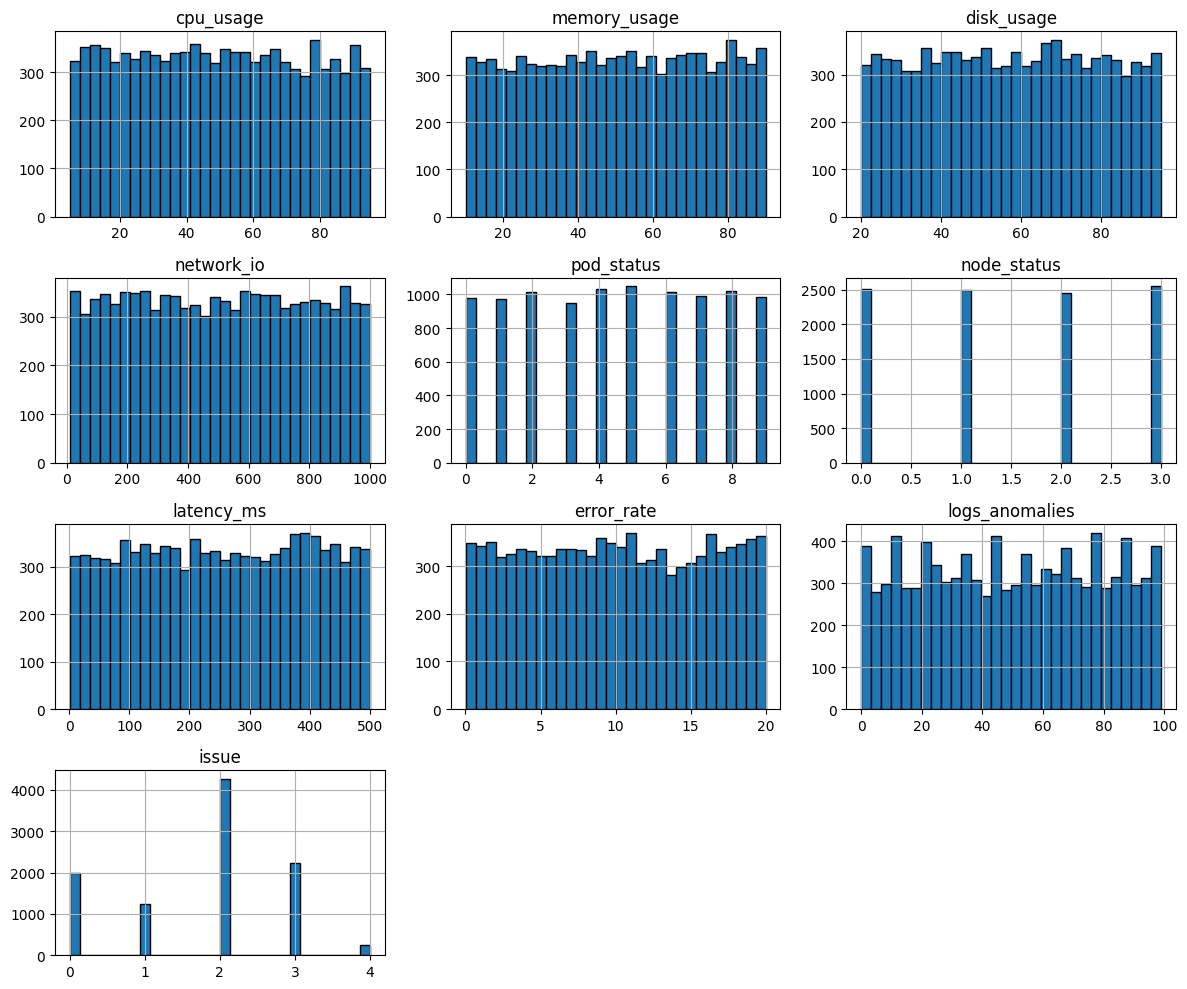

In [ ]:
df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


In [12]:
np.random.seed(42)

In [13]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.drop("timestamp", axis=1, inplace=True)


In [21]:
df["issue"].value_counts()

issue
2    4268
3    2245
0    1990
1    1239
4     258
Name: count, dtype: int64

In [14]:

le = LabelEncoder()
df["issue"] = le.fit_transform(df["issue"])

In [15]:
X = df.drop("issue", axis=1)
y = df["issue"]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:

model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8)
model.fit(X_train, y_train)

c:\Users\Rudrresh\miniconda3\envs\tensorflow\lib\site-packages\xgboost\training.py:183: UserWarning: [12:15:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)

In [20]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.996
                     precision    recall  f1-score   support

      Network Issue       1.00      1.00      1.00       387
           No Issue       1.00      0.99      0.99       253
        Pod Failure       1.00      1.00      1.00       858
Resource Exhaustion       0.99      0.99      0.99       457
 Service Disruption       0.98      1.00      0.99        45

           accuracy                           1.00      2000
          macro avg       0.99      1.00      0.99      2000
       weighted avg       1.00      1.00      1.00      2000



In [22]:
import joblib

In [23]:
joblib.dump(model, "kubernetes_issue_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']